In [ ]:
# default_exp bayesian
%load_ext autoreload
%autoreload 2
from nbdev import *
from utilities.ipynb_docgen import *

# Bayesian Blocks

> Partition a light curve with the Bayesian Block algorithm

The algorithm depends on a 'fitness' function of the light curve, an evaluation of the 
likelihoods for a set of sequential cells. There are two such, using the number of counts, and the Kerr likelihood.

- CountFitness
- LikelihoodFitness

See the [Bayesian Block reference](https://arxiv.org/pdf/1207.5578.pdf)

In [ ]:
#export
import os
import numpy as np
import pandas as pd
from astropy.stats.bayesian_blocks import FitnessFunc
from light_curves.lightcurve import get_lightcurve, flux_plot

## Generate data sets for an AGN and a pulsar
<details class="descripton" ><summary data-open="Hide " data-close="Show "> printout </summary> <p style="margin-left: 5%"><pre>Restoring the light curve from /tmp/light_curves/Geminga_lightcurve.pkl <br>Restoring the light curve from /tmp/light_curves/3C_279_lightcurve.pkl <br></pre></p> </details>


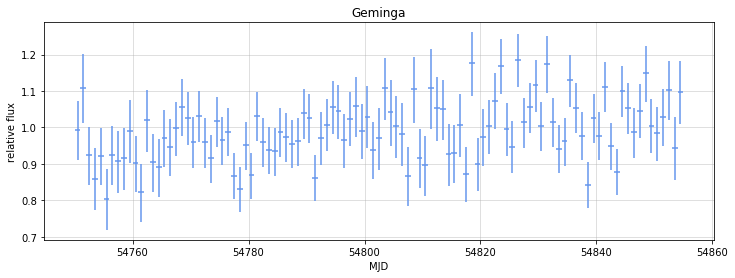

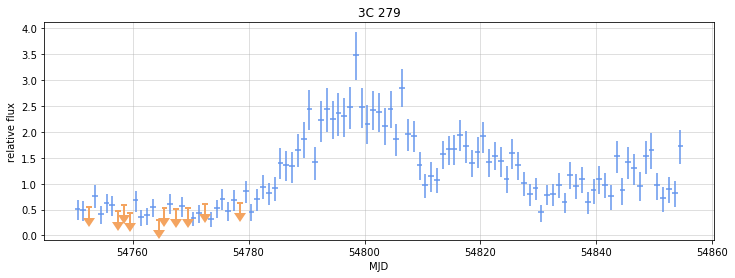

In [ ]:
#collapse_hide
lcs ={}
def data_setup(lcs = lcs, mjd_query='54750<t<54855', names=['Geminga','3C 279']):
    """
    ## Generate data sets for an AGN and a pulsar
    {printout}
    """
    
    from light_curves.config import Config, Files, PointSource
    from light_curves.lightcurve import get_lightcurve, flux_plot
    config = Config(use_cache=True)
    files = Files()
    with capture_print('printout') as printout:
        for i,name in enumerate(names):
            lc = lcs[name] = get_lightcurve(config, files, PointSource(name)).query(mjd_query)
            flux_plot(config,lc, fignum=i, title=name)
    return locals()

nbdoc(data_setup, lcs)

In [ ]:
#export
class CountFitness(FitnessFunc):
    """
    Adapted version of a astropy.stats.bayesian_blocks.FitnessFunc
    Considerably modified to give the `fitness function` access to the cell data.
    Implements the Event model using exposure instead of time.

    """

    def __init__(self, lc, p0=0.05,):
        """lc  : a LightCurve data table, with  exposure (fexp) and counts (n),
            as well as a representation of the likelihood for each cell
        """
        self.p0=p0
        self.df= df= lc
        N = self.N = len(df)
        # Invoke empirical function from Scargle 2012
        self.ncp_prior = self.p0_prior(N)

        #actual times for bin edges
        dt = df.iloc[0].tw # assume all the same
        t = np.array(df.index)
        self.mjd = np.concatenate([t-dt, [t[-1]+dt]] ) # put one at the end
        self.setup()

    def setup(self):
        df = self.df
        # counts per cell
        self.nn = df.n.values
        assert min(self.nn)>0, 'Attempt to Include a cell with no contents'

        # edges and block_length use exposure as "time"
        fexp = df.fexp.values
        self.edges = np.concatenate([[0], np.cumsum(fexp)])
        self.block_length = self.edges[-1] - self.edges

    def __str__(self):
        
        return f'{self.__class__.__name__}: {self.N} cells, spanning {self.block_length[0]:.1f} days, prior={self.ncp_prior:.1f}'
        
    def __call__(self, R):
        """ The fitness function needed for BB algorithm
        For cells 0..R return array of length R+1 of the maximum log likelihoods for combined cells
        0..R, 1..R, ... R
        """
        # exposures and corresponding counts
        w_k = self.block_length[:R + 1] - self.block_length[R + 1]
        N_k = np.cumsum(self.nn[:R + 1][::-1])[::-1]

        # Solving eq. 26 from Scargle 2012 for maximum $\lambda$ gives
        return N_k * (np.log(N_k) - np.log(w_k))

    def fit(self):
        """Fit the Bayesian Blocks model given the specified fitness function.
        Refactored version using code from bayesian_blocks.FitnesFunc.fit
        Returns
        -------
        edges : ndarray
            array containing the (M+1) edges, in MJD units, defining the M optimal bins
        """
        # This is the basic Scargle algoritm, copied almost verbatum
        # ---------------------------------------------------------------

        # arrays to store the best configuration
        N = self.N
        best = np.zeros(N, dtype=float)
        last = np.zeros(N, dtype=int)

        # ----------------------------------------------------------------
        # Start with first data cell; add one cell at each iteration
        # ----------------------------------------------------------------
        for R in range(N):

            # evaluate fitness function
            fit_vec = self(R)

            A_R = fit_vec - self.ncp_prior
            A_R[1:] += best[:R]

            i_max = np.argmax(A_R)
            last[R] = i_max
            best[R] = A_R[i_max]

        # ----------------------------------------------------------------
        # Now find changepoints by iteratively peeling off the last block
        # ----------------------------------------------------------------
        change_points = np.zeros(N, dtype=int)
        i_cp = N
        ind = N
        while True:
            i_cp -= 1
            change_points[i_cp] = ind
            if ind == 0:
                break
            ind = last[ind - 1]
        change_points = change_points[i_cp:]

        return self.mjd[change_points]

In [ ]:
#collapse_hide
from light_curves.config import Config, Files, PointSource
from light_curves.lightcurve import get_lightcurve, flux_plot

def doc_countfitness( fitness, light_curve_dict, source_name):
    """
    ### {class_name} test with source {source_name}
         
    Create object: `fn = {class_name}(lc)`
    
    Object description:   {cf}
    
    Then `cf({n})` returns the values
        {values}
   
    Finally, the partition algorthm, 'cf.fit()' returns {cffit}
    
    """
    
    lc = light_curve_dict[source_name]
    cf = fitness(lc)
    class_name = cf.__class__.__name__
    n = 10
    values  = np.array(cf(n)).round()    
    cffit = cf.fit()
    
    return locals()

if Files().valid:
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='Geminga')
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='3C 279')
     

### CountFitness test with source Geminga
     
Create object: `fn = CountFitness(lc)`

Object description:   CountFitness: 105 cells, spanning 131.0 days, prior=4.9

Then `cf(10)` returns the values
    [14517. 13066. 11631. 10160.  9106.  7634.  6573.  5174.  3960.  2747.
  1451.]

Finally, the partition algorthm, 'cf.fit()' returns [ 66 104 172]


### CountFitness test with source 3C 279
     
Create object: `fn = CountFitness(lc)`

Object description:   CountFitness: 105 cells, spanning 138.0 days, prior=4.9

Then `cf(10)` returns the values
    [1657. 1431. 1268. 1145.  919.  811.  648.  510.  379.  266.  148.]

Finally, the partition algorthm, 'cf.fit()' returns [ 66  70 101 106 123 143 172]


In [ ]:
#export
class LikelihoodFitness(CountFitness):
    """ Fitness function that uses the full likelihood
    """
    
    def __init__(self, lc,  p0=0.05, npt=25):
        self.npt = npt
        super().__init__(lc, p0)
        
    def setup(self):
        df = self.df
        N = self.N
        
        def liketable(prep):
            return prep.create_table(self.npt)
        
        self.tables = df.fit.apply(liketable).values

    def __str__(self):
        return f'{self.__class__.__name__}: {self.N} cells,  prior={self.ncp_prior:.1f}'

    def __call__(self, R):
        
        a, y  = self.tables[R]
        x = np.linspace(*a)
        y = np.zeros(self.npt)
        rv = np.empty(R+1)
        for i in range(R, -1, -1): 
            a, yi = self.tables[i]
            xi = np.linspace(*a)
            y += np.interp(x, xi, yi, left=-np.inf, right=-np.inf)
            amax = np.argmax(y)
            rv[i] =y[amax]
        return rv    

In [ ]:
if Files().valid:
    nbdoc(doc_countfitness, LikelihoodFitness, light_curve_dict = lcs, source_name='Geminga')
    nbdoc(doc_countfitness, LikelihoodFitness, light_curve_dict = lcs, source_name='3C 279')
     

### LikelihoodFitness test with source Geminga
     
Create object: `fn = LikelihoodFitness(lc)`

Object description:   LikelihoodFitness: 105 cells,  prior=4.9

Then `cf(10)` returns the values
    [-4. -4. -2. -2. -1. -1. -0. -0. -0. -0. -0.]

Finally, the partition algorthm, 'cf.fit()' returns [ 66 109 172]


### LikelihoodFitness test with source 3C 279
     
Create object: `fn = LikelihoodFitness(lc)`

Object description:   LikelihoodFitness: 105 cells,  prior=4.9

Then `cf(10)` returns the values
    [-9. -9. -8. -7. -6. -6. -5. -4. -3. -3. -0.]

Finally, the partition algorthm, 'cf.fit()' returns [ 66  95 101 105 125 143 159 172]


In [ ]:
def binned_weights(self, bins=None, contiguous=False):
    """ 
    Parameter:
        bins : None | float | array
            if None, use defaults
            Otherwise an array of MJD bin edges
        contiguous : bool
            if True ignore bins arg and use a list of contiguous exposure intervals

    Returns: a BinnedWeight object for access to each set of binned weights
        The object can be indexed, or used in a for loop
        bw[i] returns a  dict (t, tw, fexp, w, S, B)
        where t   : bin center time (MJD)
              tw  : bin width in days (assume 1 if not preseent)
              fexp: associated fractional exposure
              w   : array of weights for the time range
              S,B : predicted source, background counts for this bin
        """
    if contiguous:
        assert bins is None, 'contiguous selected'
        a, b = self.get_contiguous_exposures()
        edges = np.empty(len(a)+1)
        edges[0] = a[0]
        edges[1:-1] = 0.5*(a[1:]+b[:-1])
        edges[-1]= b[-1]
        bins = edges
    return BinnedWeights(self, bins)   

In [ ]:
#export
def get_bb_partition(config, lc, fitness_class=CountFitness, p0=0.05):    

    """Perform Bayesian Block partition of the cells found in a light curve
    
    - lc : input light curve
    - fitness_func : 
    
    return edges for partition
    """
    cells = lc
    assert 'fit' in cells.columns, 'Expect the dataframe ho have the Poisson representation'
    assert issubclass(fitness_class,CountFitness), 'fitness_class wrong'
    # Now run the astropy Bayesian Blocks code using my version of the 'event' model
    fitness = fitness_class(lc, p0=p0)
    edges = fitness.fit() 

    if config.verbose>0:
        print(f'Partitioned {fitness.N} cells into {len(edges)-1} blocks, with prior {fitness.ncp_prior:.1f}'\
              f' using {fitness.__class__.__name__} ' )
    return edges

In [ ]:
#hide

def test_bb(mjd_query='54750<t<54855'):
    files = Files()
    config = Config(use_cache=True)
    source = PointSource('Geminga')
    lc = get_lightcurve(config, files, source).query(mjd_query)
    edges = get_bb_partition(config, lc) 
    lc_fig = flux_plot(config, lc, yscale='log', title=f'{source.name} light curve')
    ax = lc_fig.axes[0]
    edges = np.concatenate([edges, [edges[-1]] ])
    for  i,t in enumerate(edges[::2]):
        t2 = edges[2*i+1]
        ax.axvspan(t, t2, color='lightcyan')
    for t in edges:
        ax.axvline(t, ls=':', color='cyan')
if Files().valid:
    test_bb()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date